In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
df = sns.load_dataset("mpg")

X_train, y_train = df[~df["horsepower"].isna()][["displacement", "acceleration"]], df[~df["horsepower"].isna()]["horsepower"]
X_pred = df[df["horsepower"].isna()][["displacement", "acceleration"]]

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_pred)
y_pred = np.round(y_pred)
df.loc[X_pred.index, "horsepower"] = y_pred
df = pd.get_dummies(df.drop("name", axis = 1), columns = ["origin"])
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin_europe,origin_japan,origin_usa
0,18.0,8,307.0,130.0,3504,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449,10.5,70,0,0,1


In [4]:
X, y = df.drop(["mpg"], axis = 1).values, df["mpg"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

In [5]:
scaler = StandardScaler()
#scaler = MinMaxScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.transform(X_val)
scaled_X_test = scaler.transform(X_test)

In [491]:
class ERegressor:
    def __init__(self, n = 100, hidden_layers = False, activation = "sigmoid", random_state = None):

        self.n = n // 2 * 2
        self.nets = []
        self.best_net = -1
        self.best_result = None
        self.validation_loss_history = []
        self.training_loss_history = []
        self.mutation_sigma = 0

        if activation == "sigmoid":
            #self.activation_function = np.vectorize(lambda x: 1 / (1 + math.exp(-x)))
            self.activation_function = lambda x: 1 / (1 + np.exp(-x))
        elif activation == "relu":
            self.activation_function = lambda x: np.maximum(0, x)
        
        if hidden_layers:
            self.layers = hidden_layers + [1]
        else:
            self.layers = [1]
        
        if random_state != None:
            np.random.seed(random_state)

    
    def fit(self, X_train, y_train, epochs = 100, validation_data = False, verbose = 0):
        X_train = np.c_[np.ones(X_train.shape[0]), X_train]

        if validation_data:
            X_val, y_val = validation_data
        
        self.layers = [X_train.shape[1]] + self.layers

        for i in range(self.n):
            self.nets += [[]]
            for j in range(len(self.layers) - 1):
                self.nets[i] += [np.random.uniform(-3, 3, (self.layers[j], self.layers[j + 1]))]

        self.y_preds = np.zeros((len(self.nets), y_train.shape[0]))
        self.nets_loss = np.zeros(len(self.nets))
        self.sorted_indecies = np.zeros(len(self.nets))

        for epoch in range(epochs):
            for i in range(len(self.nets)):
                forward_pass = X_train.T

                for j in range(0, len(self.layers) - 2):
                    forward_pass = self.activation_function(self.nets[i][j].T @ forward_pass)

                forward_pass = self.nets[i][-1].T @ forward_pass

                self.y_preds[i] = forward_pass.reshape(-1)
                self.nets_loss[i] = mean_absolute_error(y_train, self.y_preds[i])
            
            self.sorted_indecies = np.argsort(regressor.nets_loss)
            
            self.mutation_sigma = 0.1 + 5 * 1 / math.exp(epoch / (epochs / (10 * math.log10(epochs))))
            
            for i in range(0, self.n // 2, 2):
                for j in range(len(self.layers) - 1):
                    self.nets[self.sorted_indecies[self.n // 2 + i]][j] = (self.nets[self.sorted_indecies[i]][j] + self.nets[self.sorted_indecies[1 + i]][j]) / 2 + np.random.normal(0, self.mutation_sigma, (self.layers[j], self.layers[j + 1]))
                    self.nets[self.sorted_indecies[self.n // 2 + 1 + i]][j] = (self.nets[self.sorted_indecies[i]][j] + self.nets[self.sorted_indecies[1 + i]][j]) / 2 + np.random.normal(0, self.mutation_sigma, (self.layers[j], self.layers[j + 1]))

            if self.best_net != self.sorted_indecies[0]:
                self.best_net = self.sorted_indecies[0]
                self.training_loss_history += [self.nets_loss[self.best_net]]

                if validation_data:
                    self.validation_loss_history += [mean_absolute_error(y_val, self.predict(X_val))]
                    if verbose == 1:
                        print(f"Epoch {epoch} - loss: {self.training_loss_history[-1]} - val_loss: {self.validation_loss_history[-1]}")
                else:
                    if verbose == 1:
                        print(f"Epoch {epoch} - loss: {self.training_loss_history[-1]}")


    def predict(self, X):
        X = np.c_[np.ones(X.shape[0]), X]

        forward_pass = X.T
        for j in range(0, len(self.layers) - 2):
            forward_pass = self.activation_function(self.nets[self.best_net][j].T @ forward_pass)

        forward_pass = self.nets[self.best_net][-1].T @ forward_pass

        return forward_pass.reshape(-1)
        

In [493]:
regressor = ERegressor(n = 100, hidden_layers = [10], activation = "sigmoid", random_state = 42)
regressor.fit(scaled_X_train, y_train, epochs = 1000, validation_data = (scaled_X_val, y_val), verbose = 1)

Epoch 0 - loss: 16.913380212373987 - val_loss: 16.05389249924398
Epoch 1 - loss: 6.745716077039989 - val_loss: 5.935898235069212
Epoch 3 - loss: 6.214309512775501 - val_loss: 5.478099938431688
Epoch 4 - loss: 5.286557221858352 - val_loss: 6.192302068247294
Epoch 6 - loss: 4.5933954932587 - val_loss: 4.022458147223096
Epoch 8 - loss: 4.392738175349173 - val_loss: 5.6329535042181815
Epoch 15 - loss: 3.709725234486404 - val_loss: 3.7292327647159156
Epoch 36 - loss: 3.6542401322051727 - val_loss: 3.8728536927607093
Epoch 37 - loss: 3.5727345941450417 - val_loss: 3.241097655759776
Epoch 39 - loss: 3.1630053656670896 - val_loss: 2.6647700824993317
Epoch 41 - loss: 3.1035974316607424 - val_loss: 3.3307750643781033
Epoch 45 - loss: 3.094085240626637 - val_loss: 3.008355713375882
Epoch 54 - loss: 2.958796102426539 - val_loss: 2.5104818921469296
Epoch 57 - loss: 2.9246637539776015 - val_loss: 2.8347983298759396
Epoch 61 - loss: 2.847675457248234 - val_loss: 2.8158884397073347
Epoch 63 - loss: 2.

In [494]:
y_pred = regressor.predict(scaled_X_test)

In [495]:
mean_absolute_error(y_test, y_pred)

1.7604775015445242

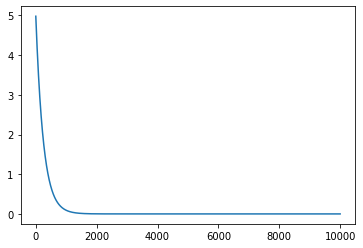

In [474]:
y = []
xrange = 10000

for x in range(1, xrange + 1):
    y.append(5 * 1 / math.exp(x / (xrange / (10 * math.log10(xrange)))))

plt.plot(list(range(xrange)), y)

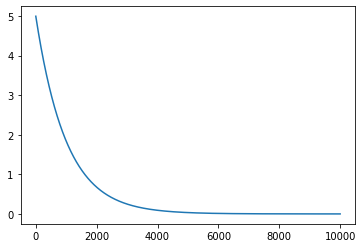

In [464]:
y = []
xrange = 10000

for x in range(1, xrange + 1):
    y.append(5 * 1 / math.exp(x / (xrange / 10)))

plt.plot(list(range(xrange)), y)